# Goal: 
Scrapped NBA top 100 prospect rankings from nbadraft.net from 2009-2020 which is all the data currently available. 
Note: Please execute the `nba_draft_college_renaming` notebook prior to this one so you understand where the manual college renaming comes from.

Import libraries in order to scrape HTML data, manipulate the dataframes, and upload into our database.

In [8]:
! pip install lxml
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup 
import pandas as pd
import re
import getpass
import psycopg2
import numpy as np
import seaborn as sns
from psycopg2.extensions import adapt, register_adapter, AsIs
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Create the dataframe where we can append annual NBA prospect rankings data into. Scrape column headers from the webpage and add Rank as a column header which is blank on the website.

In [2]:
url = "https://www.nbadraft.net/ranking/bigboard/?year-ranking=2009.html"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
soup = BeautifulSoup(webpage)
headers = [th.getText() for th in soup.findAll('tr', limit=1)[0].findAll('th')]
headers.append('Year')
headers[0] = 'Rank'

ranking_df = pd.DataFrame([], columns = headers)

In the for loop, we want to scrape the ranking dataset into a dataframe. We specifically need to scrape for the span tags since this is where all the first and last names are stored. The names are scraped into a list and then merged to form complete names. We then add a column for the year. 

In [3]:
merged_names = []
for i in range(2009, 2021, 1):
    print('Now adding in year {}'.format(i))
    url = "https://www.nbadraft.net/ranking/bigboard/?year-ranking={}.html".format(i)
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    
    ranking_stats = pd.read_html(webpage)[0]
    
    soup = BeautifulSoup(webpage)
    rows = soup.findAll('tr')[1:]    
    names = []
    for i in range(len(rows)):
        for td in rows[i].findAll('td'):
            for span in td.findAll('span'):
                names.append(span.getText())
 
    for x,y in zip(np.arange(0,len(names),2), np.arange(1,len(names),2)):
        firstName = names[x] 
        lastName = names[y]
        merged_names.append(' '.join([firstName, lastName]))
        
    ranking_df = ranking_df.append(ranking_stats,ignore_index=True)
    ranking_df['Player'] = merged_names

ranking_df.head()
ranking_df['Year'] = 0

Now adding in year 2009


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Now adding in year 2010
Now adding in year 2011
Now adding in year 2012
Now adding in year 2013
Now adding in year 2014
Now adding in year 2015
Now adding in year 2016
Now adding in year 2017
Now adding in year 2018
Now adding in year 2019
Now adding in year 2020


The rank column we intended to read data into was not able to so we need to drop our rank column that has nulls and renamed the unnamed column with the rank data to be our rank column. We also need to rename the School/Team column to remove the slashes so it can be loaded into our database. 

In [4]:
ranking_df.drop(columns = ['Rank'], inplace = True)
ranking_df.rename({'Unnamed: 0': 'Rank', 'School/Team':'School_or_Team'}, axis = 1, inplace = True)
ranking_df.head()

,Change,Class,Height,Player,Pos,School_or_Team,Rank,Weight,Year
0,1,So.,6-10,Blake Griffin,PF,Oklahoma,1.0,248,0
1,1,So.,6-5,James Harden,SG,Arizona St.,2.0,222,0
2,1,1990,6-4,Ricky Rubio,PG,FC Barcelona,3.0,180,0
3,1,Jr.,6-10,Jordan Hill,PF,Arizona,4.0,232,0
4,1,1989,6-1,Brandon Jennings,PG,Virtus Roma,5.0,170,0


Let's look at our changes. We have issues with height and year so let's fix that.

In [5]:
ranking_df.head()

,Change,Class,Height,Player,Pos,School_or_Team,Rank,Weight,Year
0,1,So.,6-10,Blake Griffin,PF,Oklahoma,1.0,248,0
1,1,So.,6-5,James Harden,SG,Arizona St.,2.0,222,0
2,1,1990,6-4,Ricky Rubio,PG,FC Barcelona,3.0,180,0
3,1,Jr.,6-10,Jordan Hill,PF,Arizona,4.0,232,0
4,1,1989,6-1,Brandon Jennings,PG,Virtus Roma,5.0,170,0


We can split the height and convert it into inches.

In [6]:
heights=[]
for index, row in ranking_df.iterrows():
    foot_inch_height = row['Height'].split('-')
    foot_inch_height = list(map(int, foot_inch_height))
    inches_height = foot_inch_height[0]*12 + foot_inch_height[1]
    heights.append(inches_height)
ranking_df['Height'] = heights

Since there are a 100 prospects per year, we can manually input the year into the Year column.

In [7]:
ranking_df.loc[0:100, 'Year'] = 2009
ranking_df.loc[100:200, 'Year'] = 2010
ranking_df.loc[200:300, 'Year'] = 2011
ranking_df.loc[300:400, 'Year'] = 2012
ranking_df.loc[400:500, 'Year'] = 2013
ranking_df.loc[500:600, 'Year'] = 2014
ranking_df.loc[600:700, 'Year'] = 2015
ranking_df.loc[700:800, 'Year'] = 2016
ranking_df.loc[800:900, 'Year'] = 2017
ranking_df.loc[900:1000, 'Year'] = 2018
ranking_df.loc[1000:1100, 'Year'] = 2019
ranking_df.loc[1100:1200, 'Year'] = 2020

Drop change column from rankings. Not relevant to our analysis since we want and already have the finalized prospect rankings.

In [8]:
ranking_df.drop(columns = ['Change'], inplace = True)

Change School Names so they match with our current dataset. We identify the names that need to be changed for proper joining in our database based on the `nba_draft_college_renaming` notebook.

In [9]:
ranking_df.replace('Arizona St.', 'Arizona State', inplace = True)
ranking_df.replace('Augusta St.', 'Augusta State', inplace = True)
ranking_df.replace('Bowling Green', 'Bowling Green State', inplace = True)
ranking_df.replace('Cleveland St.', 'Cleveland State', inplace = True)
ranking_df.replace('Colorado St.', 'Colorado State', inplace = True)
ranking_df.replace('Florida St.', 'Florida State', inplace = True)
ranking_df.replace('Fresno St.', 'Fresno State', inplace = True)
ranking_df.replace('Georgia St.', 'Georgia State', inplace = True)
ranking_df.replace('Illinois-Chicago', 'Illinois at Chicago', inplace = True)
ranking_df.replace('Iowa St.', 'Iowa State', inplace = True)
ranking_df.replace('Louisiana Lafayette', 'LA-Lafayette', inplace = True)
ranking_df.replace('Miami', 'Miami (FL)', inplace = True)
ranking_df.replace('Michigan St.', 'Michigan State', inplace = True)
ranking_df.replace('Mississippi St.', 'Mississippi State', inplace = True)
ranking_df.replace('Morehead St.', 'Morehead State', inplace = True)
ranking_df.replace('Murray St.', 'Murray State', inplace = True)
ranking_df.replace('New Mexico St.', 'New Mexico State', inplace = True)
ranking_df.replace('Norfolk St.', 'Norfolk State', inplace = True)
ranking_df.replace('Ohio St.', 'Ohio State', inplace = True)
ranking_df.replace('Oregon St.', 'Oregon State', inplace = True)
ranking_df.replace('San Diego St.', 'San Diego State', inplace = True)
ranking_df.replace('South Dakota St.', 'South Dakota State', inplace = True)
ranking_df.replace('Southern Miss.', 'Southern Mississippi', inplace = True)
ranking_df.replace("St. Johns", "St. John's (NY)", inplace = True)
ranking_df.replace("St. Louis", "Saint Louis", inplace = True)
ranking_df.replace("Tennessee-Martin", "Tennessee at Martin", inplace = True)
ranking_df.replace("Texas A&M Corpus Christi", "Texas A&M-Corpus Christi", inplace = True)
ranking_df.replace("Texas Arlington", "Texas-Arlington", inplace = True)
ranking_df.replace("UAB", "Alabama at Birmingham", inplace = True)
ranking_df.replace("UC Davis", "California, Davis", inplace = True)
ranking_df.replace("Wisconsin Green Bay", "Green Bay", inplace = True)

Log into our database and establish a connection

In [11]:
ranking_df.tail()

,Class,Height,Player,Pos,School_or_Team,Rank,Weight,Year
1195,So.,81,Kaleb Wesson,C,Ohio State,96.0,270,2020
1196,1998,83,Borisa Simanic,PF,Crvena Zvezda,97.0,205,2020
1197,2000,81,Biram Faye,SF/PF,0,98.0,225,2020
1198,Jr.,81,Garrison Brooks,PF/C,North Carolina,99.0,230,2020
1199,Jr.,86,Matt Haarms,C,Purdue,100.0,250,2020


We do not need a float data type in our rankings so we convert the column into an int data type.

In [12]:
ranking_df['Rank'] = ranking_df['Rank'].astype(int)
ranking_df.dtypes

Class             object
Height             int64
Player            object
Pos               object
School_or_Team    object
Rank               int64
Weight             int64
Year               int64
dtype: object

Connect to our database with provided credentials

In [2]:
mypasswd = getpass.getpass()
conn = psycopg2.connect(database = 'cs20_group4',
                              user = 'fhfrf',#replace with pawprint
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)

········


Create our table to match our dataframe data types

In [14]:
c_table = []
for c in ranking_df.columns:
    if ranking_df[c].dtype in [int]:
        c_table.append('{} numeric'.format(c))
    else:
        c_table.append('{} varchar({})'.format(c, 100))

Drop table if it already exists.

In [15]:
cursor = conn.cursor()
create_table = 'DROP TABLE IF EXISTS nba_top100_prospect_rankings;'
create_table += 'CREATE TABLE nba_top100_prospect_rankings ({})'.format(', '.join(c for c in c_table))
cursor.execute(create_table)
conn.commit()

Insert our dataframe into the nba_top100_prospect_rankings table

In [16]:
df = ranking_df.where(pd.notnull(ranking_df), None)
cursor = conn.cursor()
INSERT_SQL = 'INSERT INTO nba_top100_prospect_rankings'
INSERT_SQL += '({}) VALUES'.format(', '.join([x for x in df.columns]))
INSERT_SQL += '({})'.format(''.join(['%s,' * len(df.columns)])[:-1])
with conn, conn.cursor() as cursor:
    for row in df.itertuples(index=False, name=None):
        cursor.execute(INSERT_SQL, row)

Test our database to see if the data is present in our new table.

In [5]:
rankings = pd.read_sql_query('SELECT * from nba_top100_prospect_rankings', con = conn)
rankings.head()

,class,height,player,pos,school_or_team,rank,weight,year
0,So.,82.0,Blake Griffin,PF,Oklahoma,1.0,248.0,2009.0
1,So.,77.0,James Harden,SG,Arizona State,2.0,222.0,2009.0
2,1990,76.0,Ricky Rubio,PG,FC Barcelona,3.0,180.0,2009.0
3,Jr.,82.0,Jordan Hill,PF,Arizona,4.0,232.0,2009.0
4,1989,73.0,Brandon Jennings,PG,Virtus Roma,5.0,170.0,2009.0


Here are the basic statistics for our numerical values in our dataset. The ranges match what we would expect for these values.

In [10]:
rankings.describe()

,height,rank,weight,year
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,78.785000,50.500000,214.350833,2014.500000
std,3.300179,28.878105,25.218301,3.453492
min,69.000000,1.000000,150.000000,2009.000000
25%,77.000000,25.750000,195.000000,2011.750000
50%,79.000000,50.500000,213.000000,2014.500000
75%,81.000000,75.250000,230.000000,2017.250000
max,90.000000,100.000000,360.000000,2020.000000


Here is a distribution plot of our top 100 prospects' heights.

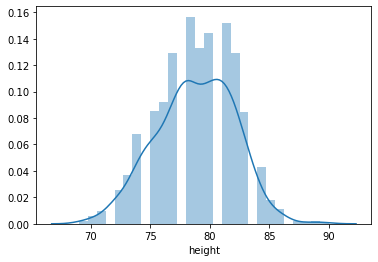

In [9]:
sns.distplot(rankings['height'])

Here is a distribution plot of our top 100 prospects' weights. 

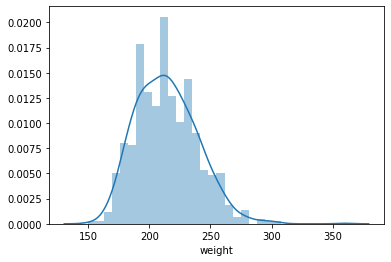

In [12]:
sns.distplot(rankings['weight'])

Let's look at the colleges/institutions that have produced the most "ranked" NBA prospects.

In [37]:
rankings.groupby('school_or_team').agg('count')['player'].sort_values(ascending = False).head(15)

school_or_team
Kentucky          47
Duke              34
Kansas            30
North Carolina    26
Arizona           25
Syracuse          24
Gonzaga           22
Texas             19
Louisville        19
Florida           17
UCLA              17
Michigan          17
Washington        16
Villanova         14
Florida State     14
Name: player, dtype: int64

Let's look at which colleges/institutions have produced the most lottery-position NBA prospects (ranked 14th or higher). 

In [36]:
top_players = rankings.loc[rankings['rank'] < 14]
top_players.groupby('school_or_team').agg('count')['player'].sort_values(ascending = False).head(15)

school_or_team
Kentucky            17
Duke                15
Arizona              7
North Carolina       7
Kansas               6
Washington           5
Texas                5
UConn                4
Michigan State       3
Oklahoma             3
Ohio State           3
Indiana              3
Gonzaga              3
Florida State        3
Maccabi Tel Aviv     2
Name: player, dtype: int64